# CNN Forward and Backward(Application)

In [1]:
import numpy as np
from utils import *
import matplotlib.pyplot as plt
from keras.datasets import mnist

Using TensorFlow backend.


## 前言

在模型创建之前,我们要先来看看什么是计算机中的图片,为了讲述方便,我们这里拟生成1张$(4\times 4\times 3)$的图片

In [2]:
np.random.seed(432)
image = np.random.rand(1,4,4,3)
print('image is:\n',image)

image is:
 [[[[0.90366057 0.89601028 0.58995011]
   [0.98727338 0.8516035  0.20881651]
   [0.76662286 0.03280564 0.29674602]
   [0.57035959 0.83466854 0.16072966]]

  [[0.34841114 0.03089059 0.98635311]
   [0.50147651 0.43779437 0.65269985]
   [0.47098865 0.94848052 0.58783855]
   [0.0203519  0.81767704 0.97718902]]

  [[0.17734062 0.84989453 0.90663793]
   [0.6995828  0.71729717 0.57699405]
   [0.39880399 0.2461832  0.52378494]
   [0.4713492  0.02030052 0.63465865]]

  [[0.9279022  0.88884168 0.70394648]
   [0.20400131 0.83652811 0.77435923]
   [0.91949173 0.56923432 0.77944544]
   [0.18595296 0.86888762 0.66068526]]]]


Text(0.5, 1.0, 'image1')

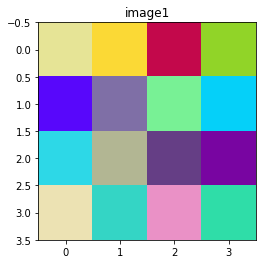

In [3]:
plt.imshow(image[0])
plt.title('image1')

图片大小为$(4\times 4)$,在Matlibplotlib 中Channels的排布为$R,G,B$.

<img src="../../picture/167.png" width=700 height=700>


也就是说:上面随机产生的image,数组形状为$(smaple,height,width,channels)$,也就是说,每一个$height$有4个$width$,组合起来就是$(16\times 3)$.

## CNN Model

我们以CNN(Theory)中的模型为例子(Single Sample):

<img src="../../picture/156.png" width=700 height=700>

## 1.Load Dtaset

这里我们采用手写数字,因为LeNet-5是用于最早识别数字的网络.

由于原模型输入是$(32\times 32 \times3)$,而我们这里的数据是$(28\times 28)$,所以第一层我们采用padding,使之得到$(28\times 28\times6)$的结果.

接下来我们有两个方案可选:

1.将原图转换为$(28\times 28\times 1)$的形式,那么CONV1的$W^{[1]}=(5,5,1,6)$.

2.原图依然为$(28\times 28)$,那么CONV1的$W^{[1]}=(5,5,6)$.

这里我选择第一种形似,其目的为为了说明$Channels$.在代码中的使用.

之后的模型部分不变.

In [4]:
def Load_data(index,limit_train,limit_test):
    (X_train,Y_train),(X_test,Y_test) = mnist.load_data()
    x_train = X_train[:limit_train,...].reshape(-1,28,28,1)
    x_test = X_test[:limit_test,...].reshape(-1,28,28,1)
    
    n_classes = len(np.unique(Y_train))
    y_train = np.eye(n_classes)[Y_train[:limit_train,...]].T
    y_test = np.eye(n_classes)[Y_test[:limit_test,...]].T
    
    print('x_train reshape:\n',x_train.shape)
    print('x_test reshape:\n',x_test.shape)
    print('Hot y_train shape:\n ',y_train.shape)
    print('Hot y_test shape:\n ',y_test.shape)
    print('The Number is:{}'.format(Y_train[index]))
    plt.imshow(X_train[index],cmap='gray')
    plt.show()
    
    return x_train/255,x_test/255,y_train,y_test

x_train reshape:
 (100, 28, 28, 1)
x_test reshape:
 (10, 28, 28, 1)
Hot y_train shape:
  (10, 100)
Hot y_test shape:
  (10, 10)
The Number is:5


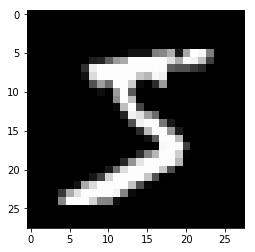

In [5]:
x_train,x_test,y_train,y_test = Load_data(0,100,10)

## 2.CONV Forward

### 2.0 Initialization  Parameters

对于整个模型,我们需要将整个模型的参数初始化.

[1] CONV1:

- $W^{[1]}shape:(5\times 5\times 1\times 6)$

- $b^{[1]}shape:(1\times 1\times 6)$

[2] CONV2:

- $W^{[2]}shape:(5\times 5\times 6\times 16)$

- $b^{[2]}shape:(1\times 1\times 16)$

[3] FC3:

- $W^{[3]}shape:(120\times 400)$

- $b^{[3]}shape:(120\times 1)$

[4] FC4:

- $W^{[4]}shape:(84\times 120)$

- $b^{[4]}shape:(84\times 1)$

[5] FC5:

- $W^{[5]}shape:(10\times 84)$

- $b^{[5]}shape:(10\times 1)$

In [6]:
def initial_parameters():
    np.random.seed(2)
    parameters = {}
    
    V = {}
    M = {}
    
    W1 = np.random.randn(5,5,1,6) / np.sqrt(28*28*1)
    b1 = np.zeros((1,1,6))
    W2 = np.random.randn(5,5,6,16) / np.sqrt(5*5*1*6)
    b2 = np.zeros((1,1,16))
    W3 = np.random.randn(120,400) / np.sqrt(400)
    b3 = np.zeros((120,1))
    W4 = np.random.randn(84,120) / np.sqrt(120)
    b4 = np.zeros((84,1))
    W5 = np.random.randn(10,84) / np.sqrt(84)
    b5 = np.zeros((10,1))
    
    parameters['W1'],V['V_dW1'],M['M_dW1'] = W1,np.zeros(W1.shape),np.zeros(W1.shape)
    parameters['b1'],V['V_db1'],M['M_db1'] = b1,np.zeros(b1.shape),np.zeros(b1.shape) 
    parameters['W2'],V['V_dW2'],M['M_dW2'] = W2,np.zeros(W2.shape),np.zeros(W2.shape) 
    parameters['b2'],V['V_db2'],M['M_db2'] = b2,np.zeros(b2.shape),np.zeros(b2.shape) 
    parameters['W3'],V['V_dW3'],M['M_dW3'] = W3,np.zeros(W3.shape),np.zeros(W3.shape)
    parameters['b3'],V['V_db3'],M['M_db3'] = b3,np.zeros(b3.shape),np.zeros(b3.shape) 
    parameters['W4'],V['V_dW4'],M['M_dW4'] = W4,np.zeros(W4.shape),np.zeros(W4.shape)
    parameters['b4'],V['V_db4'],M['M_db4'] = b4,np.zeros(b4.shape),np.zeros(b4.shape)
    parameters['W5'],V['V_dW5'],M['M_dW5'] = W5,np.zeros(W5.shape),np.zeros(W5.shape)
    parameters['b5'],V['V_db5'],M['M_db5'] = b5,np.zeros(b5.shape),np.zeros(b5.shape)
    
    
    
    return parameters,V,M

### 2.1 Padding

实际上在Nump中,我们可以直接将数组进行pad,详情请看[np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html):

我们可以使用```np.pad(arr3D, ((0, 0),(1,1),(2,2),(0,0)), 'constant',constant_values=(6,7))```来padding.

其中元组```((0, 0),(1,1),(2,2))```表示第一维度不填充(因为我们这里表示的是样本数量),第二维度左右填充数量为1,第三维度左右填充数量为2,第四维度不填充(因为我们这里表示的是Channels),填充的方式为"constant",填充的值(constant_values)为左为6,右为7.

如果有更多维度:

if you want to pad the array "a" of shape $(5,5,5,5,5)$ with pad = 1 for the 2nd dimension, pad = 3 for the 4th dimension and pad = 0 for the rest, you would do:

a = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), 'constant', constant_values = (..,..))


所以如果数据排列是(m, n_H,n_W,n_C)我们需要的形式如下:

```np.pad(data, pad_width=((0,0),(padder,padder),(padder,padder),(0,0)),mode='constant',constant_values=(0,0))```

返回的将是:

```(m, n_H + 2*pad, n_W + 2*pad, n_C)```

**Reference:**

[1] [图文并茂的Python教程-numpy.pad](https://blog.csdn.net/hustqb/article/details/77726660)

In [7]:
def Padding(data,padder_h=0,padder_w=0):
    """
    Implmention padding layer.
    
    Arguments:
    ---------
        data: python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
        size: padd width.
        padder: padd value defaule 0.incloud padder_h and padder_w.
    Return:
    ------
        res_padd: padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    res_padd = np.pad(data, pad_width=((0,0),(padder_h,padder_h),(padder_w,padder_w),(0,0)),mode='constant',constant_values=(0,0))
    
    return res_padd

假设我们需要将第两张图片矩阵padding,其中$p=4$

In [8]:
test = x_train[0:2,...]
padd_test = Padding(test,4,4)
print('Original data shape is:\n',test.shape)
print('Padd 1 data shape is:\n',padd_test.shape)

Original data shape is:
 (2, 28, 28, 1)
Padd 1 data shape is:
 (2, 36, 36, 1)


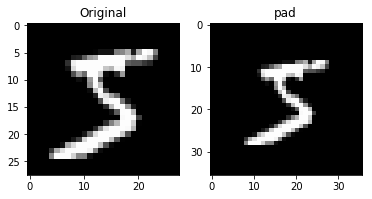

In [9]:
fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('Original')
axarr[0].imshow(test[0,:,:,0],cmap='gray')
axarr[1].set_title('pad')
axarr[1].imshow(padd_test[0,:,:,0],cmap='gray')

仔细观察可以发下,pad图的高和宽要大于Original.

### 2.2 CONV layers

这里我们是用im2col进行卷积操作,我们知道im2col的效率会比for loop速度快很多,并将padding融入到CONV中.


**Note:**

> 在灰度图中(3. CNN Edges)我们使用的是```im2col_data = np.zeros((f*f,conv_H*conv_W))```,也就是说,最后的卷积操作实际上是卷积核kernel与矩阵中的```f*f```做点积.那么对于现在多Channels的情况,我们也可以写出类似的代码```np.zeros((m,f_h*f_w*f_c,conv_H*conv_W))```,也就是说,无论添加多少样本,多少Channels,卷积核依然只是和感受野内的元素做点积.

> 实际上就是:```im2col_data = np.zeros((f*f,conv_H*conv_W))``` 等价于```im2col_data = np.zeros((1,f*f*1,conv_H*conv_W))```.

> 之后的展平卷积核与im2col_data点成注意维度就行了.

In [10]:
def CONV(data,kernel,bias,stride,padd="SAME"):
    """
    Implemention img2col of CONV.
    Arguments:
    ----------
        data: Input data, the shape is (m,n_h,n_w,n_c).
        kernel: conv Weights, the shape is (f_h,f_w,f_c,#f),usually,f_h = f_w,f_c = n_c
        stride: conv kernel stride.
        padd: input shape euqal output shape,choose "SAME". if padding=0,choose "Valid".default "SAME".
        
    Return:
    -------
        CONV_im2col_data: conv result.shape is (m,CONV_h,CONV_w,#f).
        CONV_h: floor{(n_h+2*p-f_h)/s + 1}
        CONV_w: floor{(n_w+2*p-f_w)/s + 1}
    """
    m,n_h,n_w,n_c = data.shape
    f_h,f_w,f_c,f_m = kernel.shape
    
    if padd == "SAME":
        p_h = int((f_h-1)/2) # padding height
        p_w = int((f_w-1)/2) # padding width
        data = Padding(data,p_h,p_w)
    elif padd == "Valid":
        p_h = 0
        p_w = 0
        data = data
    else:
        raise ValueError('%s is Error!'%padd)
    
    
    conv_H = np.int(np.floor((n_h+2*p_h-f_h)/stride +1))
    conv_W = np.int(np.floor((n_w+2*p_w-f_w)/stride +1))
    
    
    ############### cache im2col result #################
    X_col = np.zeros((m,f_h*f_w*f_c,conv_H*conv_W))
    ################### end #############################

    for index in range(m):
        count = 0
        for i in range(conv_H):
            for j in range(conv_W):
                son_data = data[index,i*stride:(i*stride+f_h),j*stride:(j*stride+f_w),:] # get receptive field.
                
                X_col[index,:,count] = son_data.flatten() # flatten matrix.
                count +=1
    
    ###########################  dot kernel and im2col matrix ################
    W_row = kernel.reshape(f_m,-1)
    CONV_im2col_data = np.dot(W_row,X_col).reshape(m,conv_H,conv_W,f_m) + bias
    ###############################  end #####################################
    
    return CONV_im2col_data,stride


接下来我们使用一张图片来尝试一下模型中的CONV1$f=5,s=1$

因为我们要保证输出为$28\times 28$,所以我们需要选择```padd="SAME"```

我们先使用soble卷积核和随机初始化$W1$来看看效果.

In [11]:
conv_soble = np.array([[1,0,-1],[2,0,-2],[1,0,-1]]).reshape((3,3,1,1))
print('Kerneka shape is: ',conv_soble.shape)
bias_soble = np.zeros((1,1,1,1))
CONV_soble,_ = CONV(x_train[0:2,...],conv_soble,bias=bias_soble,stride=1,padd="SAME")
print('CONV result shape is: ',CONV_soble.shape)

Kerneka shape is:  (3, 3, 1, 1)
CONV result shape is:  (2, 28, 28, 1)


In [12]:
parameters,_,_ = initial_parameters()
W1 = parameters['W1']
b1 = parameters['b1']
print('Kerneka shape is: ',W1.shape)
CONV_W1,_ = CONV(x_train[0:2,...],W1,bias=b1,stride=1,padd="SAME")
print('CONV result shape is: ',CONV_W1.shape)

Kerneka shape is:  (5, 5, 1, 6)
CONV result shape is:  (2, 28, 28, 6)


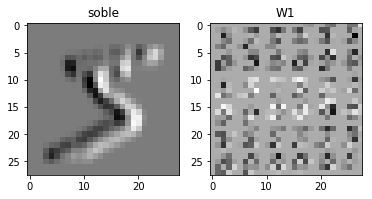

In [13]:
fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('soble')
axarr[0].imshow(CONV_soble[0,:,:,0],cmap='gray')
axarr[1].set_title('W1')
axarr[1].imshow(CONV_W1[0,:,:,0],cmap='gray')
plt.show()

可以看到soble的效果是对的,由于我们的$W1$是随机初始化,所以在训练前效果肯定是不好的.

### 2.3 Pooling layers

Pooling layers 依然可以使用im2col,只是最后求"Max" or "AVERAGE"无需求```np.dot()```.

一般我们不在Pooling层中使用padding,另外感受野的大小一般是$f=3,s=2$,或者$f=2,s=2$.很少有$f_w \neq f_h$的,所以我们这里不包含这种情况.

**Note:**

> 在灰度图中(3. CNN Edges)我们使用的是:```im2col_pool = np.zeros((f*f,conv_H*conv_W))```,也就是说,我们比求的是```f*f```中的结果,也就是一个感受野内的特征.

> 但是现在是多Channels的情况,我们可以仿照思想写出```X_pool = np.zeros((m,f*f,pool_H*pool_W,n_c))```,也就说,我们只是单纯的增加维度,应为无论样本数是多少,Channels是多少,我们依然还是求```f*f```感受野内的最大值或者平均值,也就是说:

> ```im2col_pool = np.zeros((f*f,conv_H*conv_W))``` 等价于```im2col_pool = np.zeros((1,f*f,conv_H*conv_W,1))```.

> 需要注意的是,我们已经不能单纯的使用```son_data.flatten()```了,因为我们现在含有Channels,需要使用```son_data.reshape(-1,n_c)```.也就是说实际上在灰度图中```son_data.flatten()```等价于```son_data.reshape(-1,1)```.

In [14]:
def Pool(data,pool_dict,padd="Valid",method="MAX"):
    """
    Implemention Pool layer.
    
    Arguments:
    ----------
        data: Pool data,the shape is (m,n_h,n_w,n_c).
        pool_dict: This a dictionary, include f(filter,f_h,f_w) and s(stride).
        padd:padding method,can choose "SAME" or "Valid", default "Valid".
        method: Pool method default "MAX". can choose "AVERAGE".
    Returns:
    -------
        Pool_im2col_data: Pooling result,the shape is (m,pool_H,pool_W,n_c).
    """
    cache_P = {}
    m,n_h,n_w,n_c = data.shape
    f_h,f_w = pool_dict['f_h'],pool_dict['f_w']
    s = pool_dict['s']
    
    cache_P['n_h'],cache_P['n_w'],cache_P['method'],cache_P['f_h'],cache_P['f_w'],cache_P['s']=n_h,n_w,method,f_h,f_w,s
    
    
    if padd == "SAME":
        p_h = int((f_h-1)/2)
        p_w = int((f_w-1)/2)
        data = Padding(data,p_h,p_w)
    elif padd == "Valid":
        p = 0
        data = data
    else:
        raise ValueError('%s is Error!'%padd)
    
    
    pool_H = np.int(np.floor((n_h+2*p-f_h)/s +1))
    pool_W = np.int(np.floor((n_w+2*p-f_w)/s +1))
    cache_P['pool_H'],cache_P['pool_W'] = pool_H,pool_W
    
    
    ############### cache im2col result #################
    # X_pool shape is (m,f*f,p_h*p+w,n_c),              #
    # so in the "MAX or AVERAGE" comparison below use   #
    # axis=1.                                           #
    X_pool = np.zeros((m,f_h*f_w,pool_H*pool_W,n_c))
    ################### end #############################

    for index in range(m):
        count = 0 
        for i in range(pool_H):
            for j in range(pool_W):
                son_data = data[index,i*s:(i*s+f_h),j*s:(j*s+f_w),:] # get receptive field.
                
                son_data = son_data.reshape(-1,n_c)
                X_pool[index,:,count,:] += son_data # flatten matrix.
                count += 1
    
   ###########################  choose method inim2col matrix ################
    if method == "MAX":
        Pool_im2col_data = np.max(X_pool,axis=1,keepdims=True).reshape(m,pool_H,pool_W,n_c)
        Arg_Max_Pool = np.argmax(X_pool,axis=1)
        cache_P['Arg_Max_Pool'] = Arg_Max_Pool
        
    elif method == "AVERAGE":
        Pool_im2col_data = np.mean(X_pool,axis=1,keepdims=True).reshape(m,pool_H,pool_W,n_c)
        
    else:
        raise ValueError('%s method Error!'%method)
    ###############################  end #####################################
    
    return Pool_im2col_data,cache_P

同样用soble卷积后的结果和随机初始化$W1$卷积后的结果来看看Pool的效果.

In [15]:
pool_dict = {'f_h':2,'f_w':2,'s':2}
Pool_soble,_= Pool(CONV_soble,pool_dict,padd="Valid",method="MAX")
print('Pool result shape is: ',Pool_soble.shape)

Pool result shape is:  (2, 14, 14, 1)


In [16]:
pool_dict = {'f_h':2,'f_w':2,'s':2}
Pool_W1,cache_W1_P = Pool(CONV_W1,pool_dict,padd="Valid",method="MAX")
print('Pool result shape is: ',Pool_W1.shape)

Pool result shape is:  (2, 14, 14, 6)


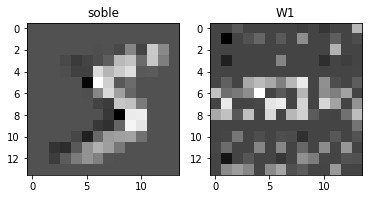

In [17]:
fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('soble')
axarr[0].imshow(Pool_soble[0,:,:,0],cmap='gray')
axarr[1].set_title('W1')
axarr[1].imshow(Pool_W1[0,:,:,0],cmap='gray')
plt.show()

可以看Pool的结果是为原来的一半,因为$f=2,s=2$.可以看到特征会更加明显.

### 2.4 FC(Fully connected layer)

我们知道全连接层实际上和DNN中是一样的,所以我们直接定义

In [18]:
def FC(data,Weights,bias):
    out = np.dot(Weights,data) + bias
    return out

### 3 Forward

In [19]:
def CNN_Forward(data,parameters):
    """
    Forward propagation of CNN.
    
    Arguments:
    ---------
        data: training data set. shape is (m,n_h,n_w,n_c)
        parameters: Initialization parameters,include weigths and bias.
    
    Returns:
    -------
        A5: output layer value.
        cache_fp: cache linear value or activation values,using in backward.
        cache_Pool: cache stride or something,using in backward.
    """
    Z1,stride_1 = CONV(data,parameters['W1'],parameters['b1'],stride=1,padd="SAME")
    A1 = relu(Z1)
    P1,cache_P1 = Pool(A1,{'f_h':2,'f_w':2,'s':2},padd='Valid',method='MAX')
    
    Z2,stride_2 = CONV(P1,parameters['W2'],parameters['b2'],stride=1,padd="Valid")
    A2 = relu(Z2)
    P2,cache_P2 = Pool(A2,{'f_h':2,'f_w':2,'s':2},padd="Valid",method="MAX")
    
    Flatten = P2.reshape(-1,P2.shape[0])
    
    Z3 = FC(Flatten,parameters['W3'],parameters['b3'])
    A3 = relu(Z3)
    
    Z4 = FC(A3,parameters['W4'],parameters['b4'])
    A4 = relu(Z4)
    Z5 = FC(A4,parameters['W5'],parameters['b5'])
    A5 = softmax(Z5)
    
    cache_fp = (data,Z1,A1,P1,Z2,A2,P2,Flatten,Z3,A3,Z4,A4,Z5,stride_1,stride_2)
    cache_Pool = {'cache_Pool1':cache_P1,'cache_Pool2':cache_P2}
    return A5,cache_fp,cache_Pool

In [20]:
parameters,V,M = initial_parameters()
A5,cache_fp,cache_Pool = CNN_Forward(x_train,parameters)
print('Out layer shape is: ',A5.shape)

Out layer shape is:  (10, 100)


下面我们来看看损失

In [21]:
loss = Loss(A5,y_train)
print('The loss is: ',loss)

The loss is:  2.3026982474509294


### 4. Backward

#### 4.1 dPool

在理解CNN的Pool BP前,我们先来重新回顾一下计算机中的图片:
<img src="../../picture/167.png" width=700 height=700>


如果以$f=2,s=2$,的感受野在图片上滑动,那么实际上走的数组为:



In [22]:
First = image[0,0:2,0:2,:]
print('First receptive field is:\n',First)
Second = image[0,0:2,2:4,:]
print('Second receptive field is:\n',Second)
Third = image[0,2:4,0:2,:]
print('Third receptive field is:\n',First)
Fourth = image[0,2:4,2:4,:]
print('Fourth receptive field is:\n',First)

First receptive field is:
 [[[0.90366057 0.89601028 0.58995011]
  [0.98727338 0.8516035  0.20881651]]

 [[0.34841114 0.03089059 0.98635311]
  [0.50147651 0.43779437 0.65269985]]]
Second receptive field is:
 [[[0.76662286 0.03280564 0.29674602]
  [0.57035959 0.83466854 0.16072966]]

 [[0.47098865 0.94848052 0.58783855]
  [0.0203519  0.81767704 0.97718902]]]
Third receptive field is:
 [[[0.90366057 0.89601028 0.58995011]
  [0.98727338 0.8516035  0.20881651]]

 [[0.34841114 0.03089059 0.98635311]
  [0.50147651 0.43779437 0.65269985]]]
Fourth receptive field is:
 [[[0.90366057 0.89601028 0.58995011]
  [0.98727338 0.8516035  0.20881651]]

 [[0.34841114 0.03089059 0.98635311]
  [0.50147651 0.43779437 0.65269985]]]


接下去我们知道在Pooling的BP时,如果采用的是"MAX",我们需要将梯度$dP$中的值依次放回原Pooling之前大小的感受野内的最大值的位置即:

<img src="../../picture/163.png" width=700 height=700>

**Ps:**
注意这里为了演示才将BP中的值与FP输出的值令成相同.实际上其是不同的.


那么我们可以在Pool中缓存每一个感受野的最大值的索引```Arg_Max_Pool```,在Bp的时候按照位置放回即可,需要注意的是,我们这里的```Arg_Max_Pool```是将每一个感受野展平$shape(-1,n_c)$的索引,也就是说,```Arg_Max_Pool```中的索引是感受野展平为行后的最大值的索引,每一列为一个通道的最大值,如下所示:

<img src="../../picture/168.png" width=500 height=500>



黄色部分代表每一个感受野中R,G,B中最大值索引值,以黄色的框为(感受野第一次滑过)例子:R通道的最大值的索引位置在1,G通道的最大值的索引位置在0,B通道的最大值的索引在2.可以对照img看看.

所以我们在BP中放回原位的时候也需要将每一个感受野滑过的窗口展平为```𝑠ℎ𝑎𝑝𝑒(−1,n_c)```.

即:```dPool```中代码:```son_data = son_data.reshape((-1,n_c))```.

接下去假设我们的BP为```dp```.

In [23]:
np.random.seed(100)
dp = np.random.rand(1,2,2,3)
print('dp is:\n',dp)

dp is:
 [[[[0.54340494 0.27836939 0.42451759]
   [0.84477613 0.00471886 0.12156912]]

  [[0.67074908 0.82585276 0.13670659]
   [0.57509333 0.89132195 0.20920212]]]]


那么我们就需要将这些值放回到原来感受野滑过窗口$(2\times 2)$中最大值的索引位置.也就是,在```dPool```中,我们也像```Pool```中一样滑动输入值,使用```Arg_Max_Pool```将```dp```的值依次放入即可.

**小技巧:**

实际上```dp```的形状可以和```Arg_Max_Pool```一致,比如对于image,那么经过Pool之后的形状为$(1\times 2\times 2\times 3)$,将```dp```reshape为$(1\times 4\times 3)$,那么形状就和```Arg_Max_Pool```$(1\times 4\times 3)$一致,继而在窗口内还原最大值的位置时就会方便许多,因为维度一样可以保证连同$Channels$一同放入.

也就是下面的代码:

```python
data_reshape = data.reshape(m,p_h*p_w,n_c)
son_data[Arg_Max_Pool[0,count],N_C] = data_reshape[0,count]```


产生的结果为:

这里为了简洁,就展示第一个窗口,其他的可以运行代码自行比较.

<div style="float:left;border:solid 1px 000;margin:2px;"><img src="../../picture/169.png"  width="400" height="500" ></div>

<div style="float:left;border:solid 1px 000;margin:2px;"><img src="../../picture/170.png" width="400" height="500" ></div>

可以看到,这样```dp```中的值就回到了原来窗口中最大值的位置.

对于"AVEERAGE"就简单许多,我们只需要将```dp```中的元素除上感受野的大小$f\times f$再发如BP的感受野内即可:

```son_data[:,N_C] = data_reshape[0,count] / (f*f)```

产生的结果如下:

<img src="../../picture/172.png" width=300 height=300>

可以看到,窗口内每一个值都是```dp```的均值.

**Ps:**

针对于以上方法,速度会比For Loop和"Mask"方式快许多,下面时候测试$(10000\times 4\times 4\times 6)$的运行效率("Mac Book Pro")
<img src="../../picture/171.png" width=400 height=400>


#### 4.1 Pool of Backward

In [24]:
def dPool(data,cache_P):
    """
    Backward of Pooling layers.
    
    Arguments:
    ---------
        data: Derivative of Pool,the shape is (m,p_h(after pool),p_w(after pool),n_c).
        cache_P: cache dictionary of Forward Pooling layer,
                include "pool_H","pool_W",'f','s','n_h','n_w','Arg_Max_Pool'(if choose "MAX" Pool),"method".
    Returns:
    -------
        dp_0: Revert to the original Pool, shape is (m,p_h(original),p_w(original),n_c) 
    """
    m,p_h,p_w,n_c = data.shape
    pool_H,pool_W,f_h,f_w,s = cache_P['pool_H'],cache_P['pool_W'],cache_P['f_h'],cache_P['f_w'],cache_P['s']
    n_h,n_w,Arg_Max_Pool,method = cache_P['n_h'],cache_P['n_w'],cache_P['Arg_Max_Pool'],cache_P['method']
    
    data_reshape = data.reshape(m,p_h*p_w,n_c) # reshape input data.
    dp_0 = np.zeros((m,n_h,n_w,n_c)) # Revert original shape.
    
    N_C = np.array([i for i in range(n_c)])
    for index in range(m):
        count = 0
        for i in range(pool_H):
            for j in range(pool_W):
                son_data = dp_0[index,i*s:(i*s+f_h),j*s:(j*s+f_w),:] # get receptive field.
                son_data = son_data.reshape((-1,n_c))
                if method == "MAX":
                    son_data[Arg_Max_Pool[0,count],N_C] = data_reshape[0,count]
                else:
                    son_data[:,N_C] = data_reshape[0,count] / (f_h*f_w)
                    
                dp_0[index,i*s:(i*s+f_h),j*s:(j*s+f_w),:]=son_data.reshape(f_h,f_w,n_c)
                count += 1   
    return dp_0

下面我们来针对$W2$来进行测试,经过Pool后CONV2层的形状为$(2\times5\times5\times16)$:

In [25]:
cache_P = cache_Pool['cache_Pool2']
dp_test = np.random.rand(100,5,5,16) # testing dp.
dp_2 = dPool(dp_test,cache_P)
print('dp_2 shape is:\n',dp_2.shape)

dp_2 shape is:
 (100, 10, 10, 16)


#### 4.2 dCONV

现在已经能够求出$dP2$了,接下去的$dReLu(Z^{[2]})$我们可以直接写出来,那么我们来看看$dCONV$的情况

在CNN Forward and Backward(Theory01)中我们已经知道了BP时CONV的流程,实际上也是一个卷积操作.下面一步一步来分析

[0] 

> 由于我们知道$\left \lfloor \frac{n+2p-f}{s} +1 \right \rfloor \times \left \lfloor \frac{n+2p-f}{s} +1 \right \rfloor $

> 那么:

> $\frac{n_{input}+2p-f}{s} +1=n_{out}$,由于$n_{input},f,s,n_{out}$都是已知,我们就可以计算出在BP的时候外层padding的值.以上面的例子为例:

> $\frac{2+2p-2}{1}+1=3 \rightarrow p=1$

> $p = \frac{(n_{out}-1)*s+f-n_{input}}{2}$

> 以$dA$为例:

> ```kernel_root180 = np.rot90(kernel,k=2,axes=(0,1))
dA_p_h = int(((A_H-1) * stride + k_f_h - n_h) / 2)
dA_p_w = int(((A_W-1) * stride + k_f_w - n_w) / 2)
dA_dZ_pool = Padding(dZ,dA_p_h,dA_p_w)```

[1] $rot180$,对于卷积核逆时针旋转180度,我们可以使用```np.rot90(arr,k=2,axes=(0,1))```,rot90表示逆时针旋转90度,k指定旋转次数,axes表示旋转的轴.注意在CONV中我们旋转的轴为宽和高的轴.

[2] 对于已知$dZ$求$dA$的时候我们要注意(以$dZ^{[2]}$为例子):

- 我们将$dZ^{[2]}(100, 10, 10, 16)$看做样本,$dW^{[2]}(5,5,6,16)$看做卷积核,输出$dA^{[1]}(100,14,14,6)$.由于卷积操作是要保证Channels一致,所以我们需要将$dW$看做是$(5,5,16,6)$进行卷积操作.

- ```dAX_col = np.zeros((m,k_f_h*k_f_w*k_f_m,A_H*A_W)),dk_col = kernel_root180.reshape(k_f_c,-1)```

[3] 对于已知$dZ$求$dW$的时候我们要注意(以$dZ^{[2]}$为例子):

- 我们将$dZ^{[2]}(100, 10, 10, 16)$看做样本,$A^{[1]}(100,14,14,6)$看做卷积核,输出$dW^{[2]}(5,5,6,16)$.由于卷积操作是要保证Channels一致,所以我们需要将$dZ^{[2]}$看做是$(16,10,10,100)$,也就是说样本数量为16,样本高宽为10,深度为100.将$A^{[1]}$看做是$(14,14,100,6)$,也就是说卷积核高宽为14,深度为100,有6个卷积核.这样我们才能拿到正确的输出$dW^{[2]}$.

- ```dkX_col = np.zeros((k_f_m,A_H*A_W*A_m,k_f_h*k_f_w)),dA_col = A.reshape(A_C,-1)```

[4] 对于已知$dZ$求$db$的时候我们要注意(以$dZ^{[2]}$为例子):

- 由于我们的输入是$dZ^{[2]}(100, 10, 10, 16)$,我们需要变形为$reshape((-1,16))$,再按照第0轴进行求和,接着reshape为$db^{[2]}(1,1,16)$.

In [26]:
def dCONV(dZ,A,kernel,stride):
    """
    Implemention derivative CONV.
    Arguments:
    ---------
        dZ: derivative Z, shape is (m,n_h,n_w,n_c).
        A: Forward A. shape is (A_m,A_H,A_W,A_C).
        kernel: Weights. shape is (k_f_h,k_f_w,k_f_c,k_f_m).
        stride: Kernel stride in CONV.
    
    Returns:
    -------
        dA: derivative A. shape same as A.
        dW: derivative weights. shape same as W.
        db: derivative bias. shape same b.
    """
    
    m,n_h,n_w,n_c = dZ.shape
    k_f_h,k_f_w,k_f_c,k_f_m = kernel.shape # Very Important!!
    A_m,A_H,A_W,A_C = A.shape
    
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~ dA ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    kernel_root180 = np.rot90(kernel,k=2,axes=(0,1))
    dA_p_h = int(((A_H-1) * stride + k_f_h - n_h) / 2)
    dA_p_w = int(((A_W-1) * stride + k_f_w - n_w) / 2)
    dA_dZ_pool = Padding(dZ,dA_p_h,dA_p_w)
    
    dAX_col = np.zeros((m,k_f_h*k_f_w*k_f_m,A_H*A_W))
    
    for index in range(m):
        count = 0
        for i in range(A_H):
            for j in range(A_W):
                son_data = dA_dZ_pool[index,i*stride:(i*stride+k_f_h),j*stride:(j*stride+k_f_w),:] 

                dAX_col[index,:,count] = son_data.flatten() # flatten matrix.
                count +=1
    
    dk_col = kernel_root180.reshape(k_f_c,-1)
    dA = np.dot(dk_col,dAX_col).reshape(m,A_H,A_W,k_f_c)
    #~~~~~~~~~~~~~~~~~~~~~~~~~ end of dA ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~ dW ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    dZ_reshape = dZ.reshape((n_c,n_h,n_w,m))
    k_p_h = int(((k_f_h-1) * stride + A_H - n_h) / 2)
    k_p_w = int(((k_f_w-1) * stride + A_W - n_w) / 2)
    k_dZ_pool = Padding(dZ_reshape,k_p_h,k_p_w)
    A_reshape = A.reshape((A_H,A_W,A_m,A_C))
    
    dkX_col = np.zeros((k_f_m,A_H*A_W*A_m,k_f_h*k_f_w))
    
    for index in range(k_f_m):
        count = 0
        for i in range(k_f_h):
            for j in range(k_f_w):
                son_data = k_dZ_pool[index,i*stride:(i*stride+A_H),j*stride:(j*stride+A_W),:]
                dkX_col[index,:,count] = son_data.flatten() # flatten matrix.
                count +=1
            
    dA_col = A.reshape(A_C,-1)
    dk = np.dot(dA_col,dkX_col).reshape(k_f_m,k_f_h,k_f_w,k_f_c)
    dk_reshape = dk.reshape((k_f_h,k_f_w,k_f_c,k_f_m)) # reshaping original weights shape.
    dW = np.rot90(dk_reshape,k=2) / m
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~ end of dW ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~ db ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    db = np.sum(dZ.reshape((-1,n_c)),axis=0,keepdims=True) / m
    db = db.reshape((1,1,n_c))
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~ end of db ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    return dA,dW,db

现在我们按照$dZ^{[2]}$的形状模拟进行$dCONV$.

In [27]:
np.random.seed(432)
dZ2 = np.random.rand(100, 10, 10, 16)
W2 = np.random.rand(5,5,6,16)
b2 = np.random.rand(1,1,16)
P1 = np.random.rand(100,14,14,6)

In [28]:
dP,dW,db = dCONV(dZ2,P1,W2,1)
print("dP_1 shape is:",dP.shape)
print("dW_1 shape is:",dW.shape)
print("db_1 shape is:",db.shape)

dP_1 shape is: (100, 14, 14, 6)
dW_1 shape is: (5, 5, 6, 16)
db_1 shape is: (1, 1, 16)


In [29]:
for name,i in zip(['Z1','A1','P1','Z2','A2','P2','Flatten','Z3','A3','Z4','A4','Z5'],cache_fp):
    print(name,i.shape)

Z1 (100, 28, 28, 1)
A1 (100, 28, 28, 6)
P1 (100, 28, 28, 6)
Z2 (100, 14, 14, 6)
A2 (100, 10, 10, 16)
P2 (100, 10, 10, 16)
Flatten (100, 5, 5, 16)
Z3 (400, 100)
A3 (120, 100)
Z4 (120, 100)
A4 (84, 100)
Z5 (84, 100)


#### 4.3 Build Backward.

现在我们来完整构建BP.

In [30]:
def Backward(A5,y,cache_fp,cache_Pool,parameters):
    """
    Backward of CNN
    Arguments:
    ---------
        A5: output layer value.
        y: true labels.
        cache_fp:cache some layers' value in Forward propagation .
        cache_Pool:cache f,s in Pooling layers.
        parameters: include weights and bias
    Returns:
    -------
        dparameters: derivative parameters, it's a dictionary,include weights and bias.
    """
    m = y.shape[1]
    (X,Z1,A1,P1,Z2,A2,P2,Flatten,Z3,A3,Z4,A4,Z5,stride_1,stride_2) = cache_fp
    
    dZ5 = A5 - y
    
    dW5 = np.dot(dZ5,A4.T) / m
    db5 = np.sum(dZ5,axis=1,keepdims=True) / m
    dA4 = np.dot(parameters['W5'].T,dZ5)
    
    dZ4 = np.multiply(dA4,np.int64(Z4>0))
    dW4 = np.dot(dZ4,A3.T) / m
    db4 = np.sum(dZ4,axis=1,keepdims=True) / m
    dA3 = np.dot(parameters['W4'].T,dZ4)
    
    dZ3 = np.multiply(dA3,np.int64(Z3>0))
    dW3 = np.dot(dZ3,Flatten.T) / m
    db3 = np.sum(dZ3,axis=1,keepdims=True) / m
    dFlatten = np.dot(parameters['W3'].T,dZ3)
    
    dP2 = dFlatten.reshape(P2.shape)
    dA2 = dPool(dP2,cache_Pool['cache_Pool2'])
    dZ2 = np.multiply(dA2,np.int64(Z2>0))
    dP1,dW2,db2 = dCONV(dZ2,A1,parameters['W2'],stride_2)
    
    dA1 = dPool(dP1,cache_Pool['cache_Pool1'])
    dZ1 = np.multiply(dA1,np.int64(Z1>0))
    _,dW1,db1 = dCONV(dZ1,X,parameters['W1'],stride_1)
    
    dparameters = {'dW5':dW5,'db5':db5,'dW4':dW4,'db4':db4,'dW3':dW3,'db3':db3,'dW2':dW2,'db2':db2,'dW1':dW1,'db1':db1}
    return dparameters


In [31]:
parameters,V,M = initial_parameters()
A5,cache_fp,cache_Pool = CNN_Forward(x_train,parameters)
dparameters = Backward(A5,y_train,cache_fp,cache_Pool,parameters)

### Update

这里我们使用Adam Optimizer进行更新参数

In [32]:
parameters,V,M = Update(5,dparameters,parameters,V,M,beta_1=0.9,beta_2=0.999,t=1,lr=0.001)

In [33]:
A5,cache_fp,cache_Pool = CNN_Forward(x_train,parameters)
loss = Loss(A5,y_train)
print('The loss is: ',loss)

The loss is:  2.2983748424135575


可以看到损失已经下降,说明开始学习,下面我们就开始搭建CNN

### Score

我们创建评分函数

In [34]:
def Score(data,labels,parameters,is_loss=False):
    """
    Score function
    
    Arguments:
    ---------
        data: score data,the shape is (m,n_h,n_w,n_c)
        labels: score labels shape is (n_classes,m)
        parameters: include weights and bias.
        is_loss: caculate loss is is_loss equal True.
    Returns:
    -------
        accuracy: accurate 
        loss: loss value.
    """
    m = labels.shape[1]
    A5,_,_ = CNN_Forward(data,parameters)
    predict = np.argmax(A5,axis=0)
    true_labels = np.argmax(labels,axis=0)
    accuracy = np.sum(predict==true_labels)/ m
    if is_loss:
        loss = Loss(A5,labels)
        return accuracy,loss
    else:
        return accuracy

### CNN Model

In [38]:
def CNN_Model(data,labels,epochs,batch_size,lr):
    """
    Build CNN Model.
    
    Arguments:
    ---------
        data: training set. the shape is (m,n_h,n_w,n_c)
        labels: training labels. the shape is (n_classes,m)
        epochs: #Iterate.
        batch_size: Mini-batch size.
        lr:learning rate.
    """
    L = 5
    t = 0
    seed = 0
    parameters,V,M = initial_parameters()
    for epoch in range(epochs):
        seed +=1
        mini_batchs = random_mini_batche(data,labels,seed=seed,mini_batche_size=batch_size)
        for mini_x,mini_y in mini_batchs:
            t += 1
            A5,cache_fp,cache_Pool = CNN_Forward(data,parameters)
            dparameters = Backward(A5,labels,cache_fp,cache_Pool,parameters)
            parameters,V,M = Update(5,dparameters,parameters,V,M,beta_1=0.9,beta_2=0.999,t=t,lr=lr)
        if epoch % 10 ==0:
            accuracy_train,loss_train = Score(data,labels,parameters,is_loss=True)
            print('Train Loss:{} Train acc:{}'.format(loss_train,accuracy_train))

In [39]:
CNN_Model(x_train,y_train,epochs=50,batch_size=64,lr=0.001)

Train Loss:2.2946237215133336 Train acc:0.15
Train Loss:2.140223344342747 Train acc:0.4
Train Loss:1.509160990494695 Train acc:0.64
Train Loss:0.709806027763834 Train acc:0.89
Train Loss:0.2764945761805435 Train acc:1.0


由于计算异常缓慢,这里特意调小了样本数量(我这里使用的是100个训练样本),至于验证集和测试集我们也没有必要测试,因为样本量太少了.接下去我们来看看框架是如何实现的.